# Calibrating a CNN trained on CIFAR10

In [50]:
import os

import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from normalizing_flows.data.cifar import get_cifar10

from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

In [51]:
dev = torch.device('mps')

### Load model

In [52]:
weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2

cnn = mobilenet_v3_large(weights=weights)
cnn.classifier = nn.Linear(960, 10, bias=True)

preprocess = weights.transforms()

### Prepare data

In [53]:
cifar10, ix2_label = get_cifar10(data_path='../../data/cifar10', test=True)


X_train = torch.as_tensor(np.permute_dims(cifar10['images'], [0,3,1,2]))
Y_train = torch.as_tensor(cifar10['labels'])

val_idx = np.random.permutation(len(X_train))
X_val = X_train[val_idx[:5000]]
Y_val = Y_train[val_idx[:5000]]

X_train = X_train[val_idx[5000:]]
Y_train = Y_train[val_idx[5000:]]

X_test = torch.as_tensor(np.permute_dims(cifar10['test_images'], [0,3,1,2]))
Y_test = torch.as_tensor(cifar10['test_labels'])

In [54]:
training_set = TensorDataset(X_train, Y_train)
validation_set = TensorDataset(X_val, Y_val)
test_set = TensorDataset(X_test, Y_test)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 45000 instances
Validation set has 5000 instances


dog  frog  cat  cat


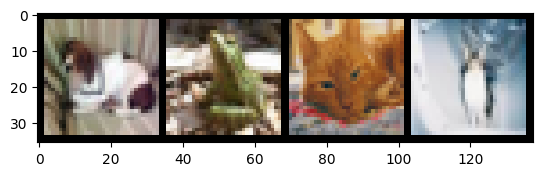

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(ix2_label[labels[j].numpy().item()] for j in range(4)))

### Train

In [56]:
optimizer = torch.optim.Adam(list(cnn.classifier.parameters()), lr=1e-3)
epochs = 100

loss_fn = torch.nn.CrossEntropyLoss()

In [57]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = cnn(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss